# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings

import seaborn as sns
#sns.set_context('paper', font_scale=1.8) "font.family": "sans-serif","font.sans-serif": ["Helvetica"],
sns.set(style="white", context="paper", font_scale=1.8, 
        rc={"text.usetex": True, 
            'font.family':'Times New Roman', 
            'font.serif':'Times New Roman', 
            "savefig.dpi": 300})
plt.rcParams['text.usetex'] = True

sns.set(style="white", context="paper", font_scale=1.8, rc={"text.usetex": True, 'font.family':'Times New Roman', 'font.serif':'Times New Roman', "savefig.dpi" : 300})
#sns.set_context('paper', font_scale=1.8) "font.family": "sans-serif","font.sans-serif": ["Helvetica"],
def configure_axes(ax):
    def set_x_label(label, size=18, labelpad=5):
        ax.set_xlabel(label, size=size, labelpad=labelpad, loc="right", fontname='serif')
    def set_y_label(label, size=18, labelpad=5):
        ax.set_ylabel(label, size=size, labelpad=labelpad, loc="top", fontname='serif')
    ax.set_x_label = set_x_label
    ax.set_y_label = set_y_label
    ax.minorticks_on() 
    ax.tick_params(direction='in', length=10, width=1.1, colors='black', which='major', top=True, right=True)
    ax.tick_params(direction='in', length=5, width=0.6, colors='black', which='minor', top=True, right=True)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    for spine in ['left', 'right', 'top', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    sns.despine(left=False, bottom=False, right=False, top=False, offset=None, trim=False)
    ax.tick_params(axis='x', labelcolor='black', labelsize=16)
    ax.tick_params(axis='y', labelcolor='black', labelsize=16)

cm = plt.colormaps['RdYlBu']


/tmp/ipykernel_665986/2154105228.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import glob,imp,os,shutil


# CMS curve

In [2]:
cmsCurve = np.genfromtxt('2Dexclusioncontour,axial,Observed.csv', skip_header=12,names=True,delimiter=',')
cmsCurve2 = np.genfromtxt('2Dexclusioncontour,vector,Observed.csv', skip_header=12,names=True,delimiter=',')


#### Create txname/process translator

In [3]:
processDict = {'TRV1tt' : r'$p p \to \bar{t} t$',
               'TRV1jj' : r'$p p \to j j$',
               'TRV1bb' : r'$p p \to \bar{b} b$',
               'TRV1qq' : r'$p p \to \bar{q} q$',
               'TRV1' : r'$p p \to \chi \chi$',
               'TRS1' : r'$p p \to \chi \chi$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    return newlabel


#### Get data in pcl format and print all columns names

In [4]:
#Merge with SModelS DataFrame
pclFiles = ['./smodels_results_monojet_gchi-1,5.pcl', './smodels_results_monojet_gchi-1.pcl', './smodels_results_monojet_add_gq_015.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
print(dataDF.columns.values.tolist()) #Print all columns names
dataDF


['filename', 'mass.9000006', 'mass.9900032', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'mass.9900026', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'extpar.5', 'extpar.6', 'extpar.7', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.chi,chi', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.zp.chi,chi', 'BRs.zp.b,b', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.t-,t+', 'BRs.sd.ta+,ta-', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus

,filename,mass.9000006,mass.9900032,mass.9000002,mass.9000003,mass.9000004,mass.9000005,mass.9900026,width.9000002,width.9000003,...,ExptRes.result0.DataSetID,ExptRes.result0.AnalysisSqrts (TeV),ExptRes.result0.lumi (fb-1),ExptRes.result0.dataType,ExptRes.result0.r,ExptRes.result0.r_expected,ExptRes.result0.Width (GeV),ExptRes.result0.likelihood,ExptRes.result0.l_max,ExptRes.result0.l_SM
0,scan_gi_f4gen.slha,146.69900,1944.8260,91.1876,79.82436,79.82436,1500.0,972.4131,2.4952,2.085,...,(combined),13.0,137.0,combined,0.677135,1.320752,-1,1.327818e-275,1.504496e-275,1.793298e-276
1,scan_okwefjcm.slha,278.52110,1972.5120,91.1876,79.82436,79.82436,1500.0,986.2562,2.4952,2.085,...,(combined),13.0,137.0,combined,0.660485,1.252914,-1,1.074316e-275,1.204753e-275,1.793298e-276
2,scan_nnoroyye.slha,110.64400,719.4325,91.1876,79.82436,79.82436,1500.0,359.7162,2.4952,2.085,...,(combined),13.0,137.0,combined,12.153760,21.197210,-1,0.000000e+00,6.645398e-276,1.793298e-276
3,scan_3fydc4s8.slha,146.72120,2337.4600,91.1876,79.82436,79.82436,1500.0,1168.7300,2.4952,2.085,...,(combined),13.0,137.0,combined,0.303071,0.561989,-1,7.555352e-276,1.013895e-275,1.793298e-276
4,scan_fton_o23.slha,394.43080,1551.0050,91.1876,79.82436,79.82436,1500.0,775.5025,2.4952,2.085,...,(combined),13.0,137.0,combined,1.459457,2.706643,"[(zp, 75.81906), (chi, stable)]",3.529817e-278,1.021130e-275,1.793298e-276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,scan_926jb7ew.slha,557.61650,2632.7180,91.1876,79.82436,79.82436,1500.0,1316.3590,2.4952,2.085,...,(combined),13.0,137.0,combined,0.082868,0.153890,"[(zp, 86.67959), (chi, stable)]",3.003494e-276,1.025842e-275,1.793298e-276
14996,scan_tok4qg05.slha,235.15140,729.6099,91.1876,79.82436,79.82436,1500.0,364.8049,2.4952,2.085,...,(combined),13.0,137.0,combined,5.068898,9.278238,"[(zp, 17.5413), (chi, stable)]",0.000000e+00,9.226541e-276,1.793298e-276
14997,scan_e3k3olq7.slha,218.67350,1180.0330,91.1876,79.82436,79.82436,1500.0,590.0167,2.4952,2.085,...,(combined),13.0,137.0,combined,2.186918,3.890216,"[(zp, 40.8848), (chi, stable)]",3.295122e-283,7.652565e-276,1.793298e-276
14998,scan_p23ypj3x.slha,89.70289,1485.1880,91.1876,79.82436,79.82436,1500.0,742.5942,2.4952,2.085,...,(combined),13.0,137.0,combined,1.046294,1.965493,"[(zp, 59.3062), (chi, stable)]",1.891108e-276,1.132405e-275,1.793298e-276


#### Set r = 0 for points with no results 

In [5]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)


#### Define exclusions

In [6]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0


### Get points excluded:

In [7]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 15000
Total excluded (LHC) = 6169
Total allowed = 8831



### Plot only excluded points for a selected $g_{q}, g_{\chi}$ pair

In [8]:
dataDF['extpar.2'].unique()


array([0.25, 1.  , 0.15])

In [9]:
dataDF['extpar.1'].unique()


array([1.5, 1. ])

### Plot exclusion regions for monojet and dijet only

In [10]:
couplingsTuples = [(1.5, 0.25), (1.5, 0.15), (1.0, 0.25)]


In [11]:
gqcolorsMono = {(1.5, 0.15):'#a6bddb', (1.0, 0.25):'#ece7f2', (1.5, 0.25):'#2b8cbe'}


In [12]:
gqLegend = []
for label, color in gqcolorsMono.items():
    l = mpatches.Patch(color=color, label=label)
    gqLegend.append(l)


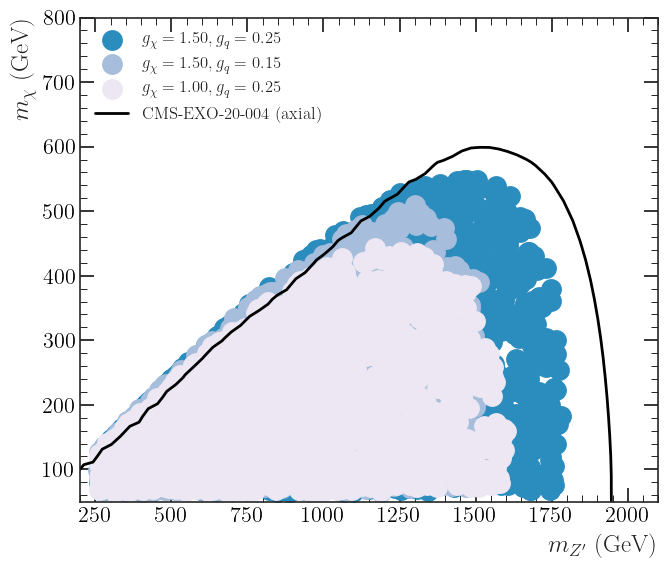

In [33]:
fig, ax = plt.subplots(figsize=(7, 6))
configure_axes(ax)

for g in couplingsTuples:
    dataj = dataDF[(dataDF['extpar.1'] == g[0]) & (dataDF['extpar.2'] == g[1])]
    
    xj = dataj['mass.9900032'][dataj['ExptRes.result0.r'] >= 1]
    yj = dataj['mass.9000006'][dataj['ExptRes.result0.r'] >= 1]

    sc = ax.scatter(xj, yj, s=200, color=gqcolorsMono[g],
                    label=r'$g_{\chi} = %1.2f, g_{q} = %1.2f$' % (g[0], g[1]))
    
ax.plot(cmsCurve['m_med_GeV'], cmsCurve['m_chi_GeV'], label='CMS-EXO-20-004 (axial)', linewidth=2, color='black')

ax.set_ylim(50, 800)
ax.set_xlim(200, 2100)

ax.set_x_label(r'$m_{Z^{\prime}}$ (GeV)')
ax.set_y_label(r'$m_{\chi}$ (GeV)')
ax.legend(loc='upper left', fontsize=12, frameon=False, ncol=1)

plt.tight_layout()
plt.savefig('./exclusions_2mdm_monojet.png')
plt.show()


In [14]:
0.25/1.5


0.16666666666666666

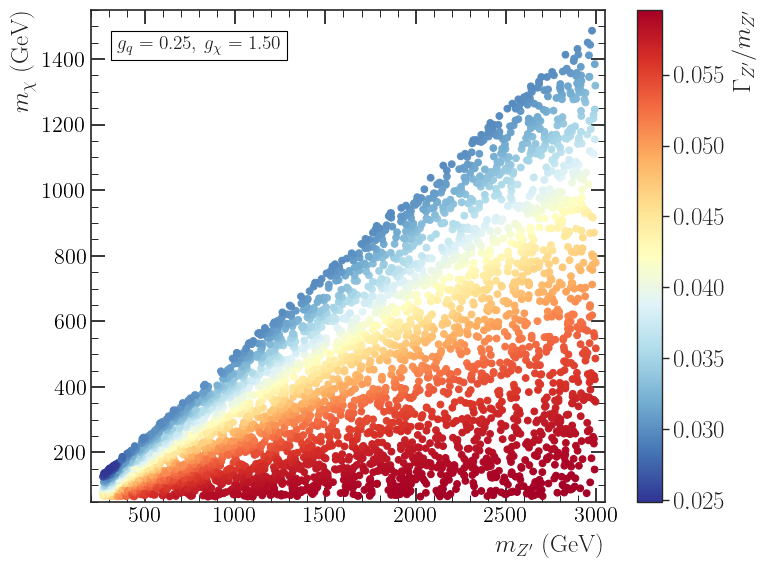

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
configure_axes(ax)
cm = plt.get_cmap('RdYlBu_r')
gchi = 1.5
gq = 0.25
dataj = dataDF[(dataDF['extpar.1'] == gchi) & (dataDF['extpar.2'] == gq)]

x = dataj['mass.9900032']
y = dataj['mass.9000006']
gamma = np.array(dataj['width.9900032'])
ratioGM = gamma / np.array(x)

sc = ax.scatter(x, y, c=ratioGM, cmap=cm)
cb = plt.colorbar(sc)
cb.ax.tick_params(labelsize=18)
cb.set_label(label=r'$\Gamma_{Z^{\prime}}/m_{Z^{\prime}}$', size=18,  loc="top")

ax.text(0.05, 0.92, r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gq, gchi), fontsize=14,
        bbox=dict(facecolor='white', edgecolor='black'), transform=plt.gca().transAxes)

ax.set_ylim(50, 1550)
ax.set_xlim(200, 3050)
ax.set_x_label(r'$m_{Z^{\prime}}$ (GeV)')
ax.set_y_label(r'$m_{\chi}$ (GeV)')

plt.tight_layout()
#plt.savefig('./figures/2mdm_ratio_wm.png')
plt.show()


In [16]:
for g in couplingsTuples:
    print(g[0], g[1])


1.5 0.25
1.5 0.15
1.0 0.25


In [17]:
dataj['mass.9900032'].min()


262.9798